In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchaudio
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt

In [5]:
class SpeechSubset(SPEECHCOMMANDS):
    def __init__(self, subset, str=None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileob:
                return [os.path.join(self._path, line.strip()) for line in fileob]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [6]:
train_set = SpeechSubset("training")
test_set = SpeechSubset("testing")

In [10]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [11]:
print("waveform         -->", waveform, "\nsample_rate      -->", sample_rate, "\nlabel            -->", label, "\nspeaker_id       -->", speaker_id, "\nutterance_number -->", utterance_number)

waveform         --> tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]]) 
sample_rate      --> 16000 
label            --> backward 
speaker_id       --> 0165e0e8 
utterance_number --> 0


Text(0.5, 1.0, 'Plot of the waveform')

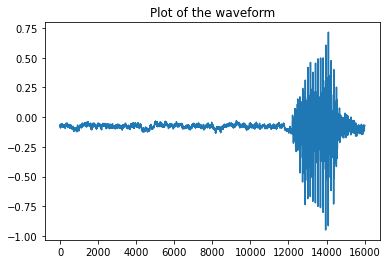

In [14]:
# This is what the waveform looks like
plt.plot(waveform.t().numpy())
plt.title("Plot of the waveform")

In [33]:
# Lets display all the labels that the commands can be classified into
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
print(labels)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [34]:
# We will make some preprocessing functions to help preprocess the data
def label_to_index(word):
  return torch.tensor(labels.index(word))

def index_to_label(index):
  return labels[index]

In [35]:
def pad_sequence(batch):
  batch = [item.t() for item in batch]
  batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True,
                                          padding_value=0.)
  return batch.permute(0, 2, 1)

In [36]:
# Processes the batch that'll be returned by the data loader
def collate_fn(batch):
  # For the dataloader that we will need for training
  # For all tensors in the batch
  tensors, targets = [], []
  for waveform, _, label, *_ in batch:
    # get waveform tensors
    tensors += [waveform]
    # encode targets (label_to_index)
    targets += [label_to_index(label)]

  # pad waveform tensors
  tensors = pad_sequence(tensors)
  # concatenate target tensors
  targets = torch.stack(targets)

  return tensors, targets

In [37]:
batch_size = 256

In [38]:
import IPython.display as ipd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [39]:
if device == 'cuda':
  num_workers = 1
  pin_memory = True
else:
  num_workers = 0
  pin_memory = False

In [40]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = batch_size,
    shuffle=True,
    collate_fn = collate_fn,
    num_workers = num_workers,
    pin_memory = pin_memory
)

In [41]:
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size = batch_size,
    shuffle=False,
    drop_last = False,
    collate_fn = collate_fn,
    num_workers = num_workers,
    pin_memory = pin_memory
)

In [42]:
# CNN with batch normalization
class M5(nn.Module):
  def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
    super().__init__()
    self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
    self.bn1 = nn.BatchNorm1d(n_channel)
    self.pool1 = nn.MaxPool1d(4)

    self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
    self.bn2 = nn.BatchNorm1d(n_channel)
    self.pool2 = nn.MaxPool1d(4)

    self.conv3 = nn.Conv1d(n_channel, 2*n_channel, kernel_size=3)
    self.bn3 = nn.BatchNorm1d(2*n_channel)
    self.pool3 = nn.MaxPool1d(4)

    self.conv4 = nn.Conv1d(2*n_channel, 2*n_channel, kernel_size=7, stride=stride)
    self.bn4 = nn.BatchNorm1d(2*n_channel)
    self.pool4 = nn.MaxPool1d(4)

    self.fc1 = nn.Linear(2*n_channel, n_output)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.pool1(x)

    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = self.pool2(x)

    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.pool3(x)

    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    #x = self.pool4(x)
    x = F.avg_pool1d(x, x.shape[-1])
    x = x.permute(0, 2, 1)
    x = self.fc1(x)
    return F.log_softmax(x, dim=2)

In [43]:
# input_size
new_sample_rate = 8000
# https://dspguru.com/dsp/faqs/multirate/resampling/
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

In [44]:
transformed.shape

torch.Size([1, 8000])

In [45]:
model = M5(n_input = transformed.shape[0], n_output=len(labels))
model.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(7,), stride=(16,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

In [46]:
def count_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [47]:
count_params(model)

43299

In [49]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [50]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)
        data = transform(data)
        output = model(data)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        pbar.update(pbar_update)
        losses.append(loss.item())

In [51]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        # if pred != target
        print("num of correct", number_of_correct(pred, target))
        correct += number_of_correct(pred, target)

        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")


In [52]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0.002188183807439825/2 [00:03<56:38, 1700.94s/it]

Train Epoch: 1 [0/105829 (0%)]	Loss: 3.577436


  2%|▏         | 0.045951859956236345/2 [01:06<55:01, 1689.61s/it]  

Train Epoch: 1 [5120/105829 (5%)]	Loss: 3.436378


  4%|▍         | 0.08971553610503279/2 [02:20<53:26, 1678.77s/it]  

Train Epoch: 1 [10240/105829 (10%)]	Loss: 3.325994


  7%|▋         | 0.1334792122538292/2 [03:34<51:44, 1663.05s/it] 

Train Epoch: 1 [15360/105829 (14%)]	Loss: 3.194376


  9%|▉         | 0.1772428884026256/2 [04:48<51:51, 1706.76s/it] 

Train Epoch: 1 [20480/105829 (19%)]	Loss: 3.132270


 11%|█         | 0.22100656455142198/2 [06:02<49:34, 1671.98s/it]

Train Epoch: 1 [25600/105829 (24%)]	Loss: 2.963084


 13%|█▎        | 0.26477024070021854/2 [07:18<50:23, 1742.58s/it]

Train Epoch: 1 [30720/105829 (29%)]	Loss: 2.820843


 15%|█▌        | 0.3085339168490155/2 [08:35<49:48, 1766.94s/it] 

Train Epoch: 1 [35840/105829 (34%)]	Loss: 2.688442


 18%|█▊        | 0.35229759299781244/2 [09:51<47:53, 1743.88s/it]

Train Epoch: 1 [40960/105829 (39%)]	Loss: 2.576667


 20%|█▉        | 0.3960612691466094/2 [11:08<47:20, 1771.04s/it] 

Train Epoch: 1 [46080/105829 (43%)]	Loss: 2.466682


 22%|██▏       | 0.43982494529540633/2 [12:47<57:51, 2224.84s/it]  

Train Epoch: 1 [51200/105829 (48%)]	Loss: 2.448638


 24%|██▍       | 0.4835886214442033/2 [14:28<54:12, 2144.84s/it]   

Train Epoch: 1 [56320/105829 (53%)]	Loss: 2.302498


 26%|██▋       | 0.5273522975929995/2 [16:19<1:08:29, 2790.67s/it] 

Train Epoch: 1 [61440/105829 (58%)]	Loss: 2.309222


 29%|██▊       | 0.5711159737417953/2 [18:09<55:37, 2335.61s/it]  

Train Epoch: 1 [66560/105829 (63%)]	Loss: 2.069779


 31%|███       | 0.6148796498905912/2 [20:04<52:47, 2286.48s/it]  

Train Epoch: 1 [71680/105829 (68%)]	Loss: 2.161341


 33%|███▎      | 0.658643326039387/2 [22:15<56:28, 2526.32s/it]   

Train Epoch: 1 [76800/105829 (72%)]	Loss: 2.085329


 35%|███▌      | 0.7024070021881829/2 [23:56<49:08, 2272.00s/it]

Train Epoch: 1 [81920/105829 (77%)]	Loss: 1.926810


 37%|███▋      | 0.7461706783369787/2 [25:55<53:53, 2578.98s/it]  

Train Epoch: 1 [87040/105829 (82%)]	Loss: 1.845947


 39%|███▉      | 0.7899343544857745/2 [27:49<55:22, 2746.03s/it]

Train Epoch: 1 [92160/105829 (87%)]	Loss: 1.896109


 42%|████▏     | 0.8336980306345704/2 [29:37<47:57, 2467.03s/it]

Train Epoch: 1 [97280/105829 (92%)]	Loss: 1.681327


 44%|████▍     | 0.8774617067833662/2 [31:22<44:17, 2367.39s/it]

Train Epoch: 1 [102400/105829 (97%)]	Loss: 1.725314


 45%|████▌     | 0.9080962800875233/2 [32:35<31:55, 1753.93s/it]

pred tensor([[22],
        [22],
        [22],
        [22],
        [ 3],
        [22],
        [11],
        [22],
        [ 1],
        [34],
        [ 7],
        [19],
        [22],
        [22],
        [18],
        [11],
        [15],
        [18],
        [23],
        [23],
        [22],
        [22],
        [22],
        [22],
        [22],
        [22],
        [ 6],
        [24],
        [22],
        [22],
        [22],
        [22],
        [15],
        [23],
        [ 6],
        [18],
        [22],
        [22],
        [22],
        [18],
        [22],
        [22],
        [22],
        [22],
        [22],
        [18],
        [18],
        [11],
        [25],
        [18],
        [15],
        [18],
        [22],
        [22],
        [ 5],
        [33],
        [25],
        [18],
        [22],
        [ 3],
        [22],
        [15],
        [22],
        [22],
        [17],
        [22],
        [ 2],
        [ 1],
        [21],
        [20],
        [33],
 

 46%|████▌     | 0.9102844638949631/2 [32:37<28:15, 1555.67s/it]

pred tensor([[21],
        [22],
        [18],
        [ 1],
        [22],
        [21],
        [25],
        [22],
        [15],
        [19],
        [22],
        [22],
        [25],
        [ 2],
        [34],
        [15],
        [ 7],
        [ 4],
        [28],
        [25],
        [22],
        [22],
        [22],
        [26],
        [ 7],
        [22],
        [33],
        [15],
        [ 2],
        [22],
        [33],
        [22],
        [22],
        [20],
        [ 5],
        [ 6],
        [22],
        [28],
        [32],
        [ 7],
        [19],
        [22],
        [27],
        [27],
        [22],
        [15],
        [22],
        [23],
        [11],
        [17],
        [22],
        [22],
        [33],
        [22],
        [ 1],
        [22],
        [26],
        [17],
        [23],
        [22],
        [22],
        [ 4],
        [22],
        [17],
        [33],
        [22],
        [15],
        [ 6],
        [22],
        [32],
        [23],
 

 46%|████▌     | 0.9124726477024029/2 [32:39<23:20, 1288.15s/it]

pred tensor([[29],
        [29],
        [25],
        [ 6],
        [ 2],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [27],
        [ 6],
        [29],
        [ 6],
        [ 6],
        [27],
        [25],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [27],
        [ 6],
        [ 6],
        [ 6],
        [29],
        [ 6],
        [ 6],
        [29],
        [ 6],
        [ 6],
        [25],
        [ 6],
        [ 6],
        [ 6],
        [25],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [25],
        [ 6],
        [25],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [27],
        [ 6],
        [25],
        [ 6],
        [25],
        [ 6],
        [ 6],
        [ 6],
        [25],
        [31],
        [ 6],
        [25],
        [25],
        [27],
        [25],
        [17],
        [ 6],
        [25],
        [25],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
 

 46%|████▌     | 0.9146608315098427/2 [32:41<22:04, 1219.90s/it]

pred tensor([[ 6],
        [ 6],
        [28],
        [27],
        [33],
        [29],
        [ 6],
        [ 6],
        [20],
        [ 6],
        [25],
        [ 6],
        [ 6],
        [25],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [27],
        [23],
        [ 6],
        [ 6],
        [ 6],
        [25],
        [27],
        [29],
        [ 6],
        [ 6],
        [ 6],
        [ 3],
        [ 6],
        [10],
        [27],
        [15],
        [25],
        [ 3],
        [25],
        [26],
        [25],
        [23],
        [ 3],
        [ 3],
        [ 3],
        [25],
        [25],
        [ 1],
        [25],
        [15],
        [15],
        [25],
        [ 3],
        [25],
        [25],
        [26],
        [13],
        [26],
        [33],
        [ 3],
        [25],
        [26],
        [19],
        [26],
        [ 3],
        [26],
        [15],
        [ 3],
        [19],
        [26],
 

 46%|████▌     | 0.9168490153172825/2 [32:43<20:31, 1137.35s/it]

pred tensor([[27],
        [ 6],
        [28],
        [28],
        [27],
        [ 6],
        [28],
        [28],
        [28],
        [29],
        [28],
        [28],
        [33],
        [28],
        [ 6],
        [28],
        [25],
        [27],
        [28],
        [29],
        [ 6],
        [29],
        [28],
        [27],
        [29],
        [28],
        [28],
        [28],
        [28],
        [28],
        [27],
        [28],
        [ 6],
        [29],
        [28],
        [28],
        [ 3],
        [28],
        [28],
        [ 6],
        [28],
        [24],
        [28],
        [28],
        [27],
        [28],
        [ 6],
        [27],
        [ 6],
        [27],
        [28],
        [27],
        [24],
        [27],
        [28],
        [28],
        [27],
        [23],
        [28],
        [28],
        [24],
        [27],
        [29],
        [27],
        [28],
        [27],
        [33],
        [28],
        [27],
        [28],
        [28],
 

 46%|████▌     | 0.9190371991247223/2 [32:46<20:26, 1134.37s/it]

pred tensor([[ 0],
        [ 0],
        [ 0],
        [23],
        [19],
        [23],
        [ 2],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [15],
        [15],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 8],
        [23],
        [ 0],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [ 0],
        [ 0],
        [26],
        [ 0],
        [ 8],
        [16],
        [24],
        [ 0],
        [ 0],
        [15],
        [10],
        [15],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [15],
        [26],
        [30],
        [ 0],
        [34],
        [34],
        [ 0],
        [ 0],
        [26],
        [ 0],
        [23],
        [23],
        [23],
        [ 0],
        [ 0],
        [ 0],
        [15],
        [ 6],
        [ 0],
        [ 0],
 

 46%|████▌     | 0.921225382932162/2 [32:48<19:47, 1100.38s/it] 

pred tensor([[23],
        [25],
        [ 1],
        [ 2],
        [ 1],
        [26],
        [10],
        [23],
        [ 1],
        [ 1],
        [ 1],
        [23],
        [ 1],
        [25],
        [17],
        [25],
        [23],
        [25],
        [23],
        [ 1],
        [25],
        [27],
        [15],
        [31],
        [25],
        [ 1],
        [25],
        [23],
        [ 1],
        [ 1],
        [28],
        [25],
        [34],
        [28],
        [30],
        [ 3],
        [33],
        [ 3],
        [33],
        [ 3],
        [11],
        [ 1],
        [23],
        [11],
        [25],
        [23],
        [12],
        [23],
        [ 3],
        [23],
        [ 6],
        [ 1],
        [ 2],
        [33],
        [23],
        [20],
        [25],
        [23],
        [23],
        [10],
        [23],
        [11],
        [20],
        [25],
        [23],
        [17],
        [11],
        [23],
        [ 2],
        [ 1],
        [11],
 

 46%|████▌     | 0.9234135667396018/2 [32:50<19:28, 1085.76s/it]

pred tensor([[12],
        [12],
        [12],
        [12],
        [12],
        [ 3],
        [25],
        [12],
        [12],
        [12],
        [25],
        [12],
        [12],
        [12],
        [27],
        [12],
        [12],
        [12],
        [30],
        [ 0],
        [ 6],
        [25],
        [12],
        [12],
        [30],
        [ 6],
        [12],
        [19],
        [12],
        [19],
        [12],
        [12],
        [ 3],
        [12],
        [12],
        [19],
        [12],
        [12],
        [12],
        [25],
        [12],
        [23],
        [12],
        [12],
        [25],
        [ 3],
        [ 0],
        [12],
        [30],
        [23],
        [12],
        [23],
        [23],
        [12],
        [25],
        [12],
        [25],
        [33],
        [12],
        [25],
        [12],
        [12],
        [26],
        [25],
        [12],
        [26],
        [23],
        [12],
        [25],
        [12],
        [23],
 

 46%|████▋     | 0.9256017505470416/2 [32:52<19:17, 1077.60s/it]

pred tensor([[11],
        [11],
        [ 5],
        [18],
        [10],
        [17],
        [10],
        [26],
        [11],
        [ 5],
        [10],
        [11],
        [22],
        [11],
        [32],
        [18],
        [34],
        [18],
        [32],
        [11],
        [18],
        [ 5],
        [11],
        [11],
        [11],
        [11],
        [11],
        [ 5],
        [11],
        [23],
        [11],
        [11],
        [11],
        [17],
        [ 5],
        [11],
        [11],
        [10],
        [11],
        [11],
        [11],
        [11],
        [34],
        [11],
        [10],
        [11],
        [18],
        [18],
        [10],
        [11],
        [11],
        [34],
        [11],
        [26],
        [29],
        [23],
        [10],
        [10],
        [10],
        [11],
        [11],
        [10],
        [24],
        [23],
        [29],
        [11],
        [11],
        [34],
        [11],
        [19],
        [29],
 

 46%|████▋     | 0.9277899343544814/2 [32:55<19:28, 1089.75s/it]

pred tensor([[11],
        [11],
        [34],
        [ 5],
        [26],
        [ 3],
        [ 5],
        [ 7],
        [ 5],
        [23],
        [11],
        [11],
        [11],
        [10],
        [11],
        [ 9],
        [11],
        [18],
        [29],
        [10],
        [11],
        [25],
        [11],
        [ 4],
        [10],
        [ 5],
        [ 1],
        [ 7],
        [11],
        [32],
        [10],
        [32],
        [ 5],
        [32],
        [ 4],
        [ 4],
        [10],
        [32],
        [ 3],
        [23],
        [ 7],
        [10],
        [20],
        [10],
        [ 6],
        [ 4],
        [13],
        [20],
        [26],
        [ 4],
        [ 5],
        [10],
        [ 1],
        [26],
        [ 5],
        [10],
        [10],
        [33],
        [23],
        [32],
        [10],
        [32],
        [ 5],
        [15],
        [10],
        [11],
        [11],
        [10],
        [19],
        [ 5],
        [26],
 

 46%|████▋     | 0.9299781181619212/2 [32:58<20:17, 1137.98s/it]

pred tensor([[18],
        [19],
        [15],
        [11],
        [17],
        [18],
        [34],
        [33],
        [18],
        [17],
        [18],
        [ 5],
        [18],
        [18],
        [17],
        [18],
        [15],
        [18],
        [18],
        [18],
        [18],
        [ 3],
        [34],
        [26],
        [24],
        [18],
        [18],
        [18],
        [18],
        [18],
        [18],
        [34],
        [18],
        [24],
        [18],
        [18],
        [34],
        [18],
        [18],
        [18],
        [11],
        [34],
        [15],
        [34],
        [18],
        [18],
        [18],
        [18],
        [15],
        [11],
        [18],
        [18],
        [18],
        [ 3],
        [15],
        [18],
        [18],
        [15],
        [23],
        [15],
        [18],
        [18],
        [18],
        [18],
        [18],
        [18],
        [18],
        [24],
        [18],
        [18],
        [18],
 

 47%|████▋     | 0.932166301969361/2 [33:00<20:42, 1163.46s/it] 

pred tensor([[11],
        [15],
        [18],
        [ 3],
        [34],
        [18],
        [11],
        [33],
        [18],
        [18],
        [24],
        [11],
        [34],
        [18],
        [18],
        [18],
        [18],
        [25],
        [18],
        [18],
        [18],
        [10],
        [23],
        [18],
        [34],
        [18],
        [18],
        [18],
        [34],
        [ 4],
        [18],
        [17],
        [34],
        [ 8],
        [ 3],
        [15],
        [18],
        [33],
        [11],
        [10],
        [18],
        [ 4],
        [18],
        [11],
        [34],
        [15],
        [34],
        [18],
        [11],
        [18],
        [18],
        [18],
        [34],
        [18],
        [18],
        [18],
        [11],
        [34],
        [18],
        [18],
        [18],
        [10],
        [24],
        [18],
        [26],
        [18],
        [18],
        [18],
        [16],
        [18],
        [18],
 

 47%|████▋     | 0.9343544857768008/2 [33:02<18:55, 1065.21s/it]

pred tensor([[11],
        [32],
        [18],
        [24],
        [32],
        [23],
        [32],
        [ 5],
        [32],
        [32],
        [32],
        [15],
        [32],
        [32],
        [32],
        [24],
        [ 7],
        [32],
        [ 5],
        [32],
        [32],
        [32],
        [32],
        [ 5],
        [32],
        [15],
        [ 4],
        [ 7],
        [ 7],
        [26],
        [32],
        [32],
        [32],
        [26],
        [ 5],
        [19],
        [32],
        [32],
        [32],
        [ 5],
        [32],
        [32],
        [32],
        [ 3],
        [32],
        [11],
        [10],
        [26],
        [21],
        [11],
        [32],
        [17],
        [32],
        [32],
        [32],
        [11],
        [32],
        [32],
        [32],
        [10],
        [26],
        [32],
        [10],
        [ 7],
        [ 3],
        [32],
        [11],
        [ 7],
        [ 7],
        [32],
        [25],
 

 47%|████▋     | 0.9365426695842406/2 [33:05<19:39, 1108.89s/it]

pred tensor([[ 8],
        [30],
        [10],
        [10],
        [17],
        [ 5],
        [22],
        [17],
        [17],
        [17],
        [ 5],
        [17],
        [17],
        [17],
        [11],
        [21],
        [17],
        [21],
        [ 3],
        [21],
        [17],
        [16],
        [17],
        [25],
        [34],
        [17],
        [17],
        [17],
        [17],
        [33],
        [22],
        [17],
        [17],
        [15],
        [ 5],
        [21],
        [22],
        [17],
        [17],
        [17],
        [17],
        [34],
        [ 5],
        [17],
        [ 5],
        [18],
        [17],
        [21],
        [17],
        [18],
        [21],
        [18],
        [17],
        [24],
        [17],
        [17],
        [17],
        [17],
        [17],
        [22],
        [18],
        [17],
        [16],
        [17],
        [17],
        [ 5],
        [ 1],
        [17],
        [21],
        [17],
        [17],
 

 47%|████▋     | 0.9387308533916804/2 [33:07<19:46, 1117.89s/it]

pred tensor([[34],
        [17],
        [25],
        [17],
        [17],
        [17],
        [ 5],
        [17],
        [17],
        [17],
        [17],
        [17],
        [17],
        [17],
        [17],
        [17],
        [ 5],
        [ 1],
        [17],
        [17],
        [17],
        [21],
        [ 5],
        [17],
        [17],
        [33],
        [17],
        [18],
        [17],
        [32],
        [17],
        [17],
        [17],
        [17],
        [ 5],
        [33],
        [21],
        [18],
        [17],
        [17],
        [23],
        [17],
        [17],
        [17],
        [18],
        [ 5],
        [17],
        [17],
        [33],
        [17],
        [18],
        [28],
        [18],
        [17],
        [17],
        [17],
        [17],
        [24],
        [34],
        [ 7],
        [25],
        [17],
        [17],
        [17],
        [23],
        [23],
        [17],
        [33],
        [17],
        [17],
        [18],
 

 47%|████▋     | 0.9409190371991202/2 [33:11<22:08, 1254.65s/it]

pred tensor([[33],
        [15],
        [30],
        [21],
        [33],
        [15],
        [15],
        [33],
        [15],
        [34],
        [15],
        [15],
        [33],
        [15],
        [15],
        [15],
        [26],
        [15],
        [33],
        [18],
        [15],
        [15],
        [15],
        [12],
        [15],
        [15],
        [15],
        [33],
        [33],
        [33],
        [15],
        [33],
        [33],
        [15],
        [15],
        [15],
        [15],
        [33],
        [15],
        [15],
        [15],
        [15],
        [33],
        [33],
        [33],
        [32],
        [33],
        [15],
        [15],
        [33],
        [15],
        [33],
        [15],
        [15],
        [24],
        [33],
        [33],
        [33],
        [15],
        [15],
        [15],
        [27],
        [33],
        [33],
        [33],
        [33],
        [15],
        [15],
        [33],
        [15],
        [15],
 

 47%|████▋     | 0.94310722100656/2 [33:13<21:04, 1196.49s/it]  

pred tensor([[15],
        [15],
        [33],
        [15],
        [34],
        [15],
        [15],
        [33],
        [15],
        [33],
        [15],
        [33],
        [33],
        [33],
        [15],
        [33],
        [33],
        [15],
        [33],
        [33],
        [33],
        [33],
        [33],
        [11],
        [18],
        [31],
        [15],
        [33],
        [15],
        [19],
        [24],
        [15],
        [ 0],
        [33],
        [15],
        [15],
        [15],
        [33],
        [23],
        [15],
        [15],
        [26],
        [15],
        [15],
        [15],
        [33],
        [10],
        [26],
        [33],
        [33],
        [15],
        [33],
        [15],
        [33],
        [33],
        [15],
        [25],
        [30],
        [26],
        [26],
        [26],
        [26],
        [26],
        [ 3],
        [26],
        [26],
        [26],
        [10],
        [11],
        [ 3],
        [26],
 

 47%|████▋     | 0.9452954048139998/2 [33:15<20:25, 1162.00s/it]

pred tensor([[ 3],
        [26],
        [19],
        [23],
        [23],
        [19],
        [26],
        [26],
        [26],
        [ 3],
        [30],
        [26],
        [19],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [30],
        [26],
        [26],
        [26],
        [ 3],
        [26],
        [26],
        [26],
        [26],
        [ 3],
        [26],
        [26],
        [26],
        [26],
        [ 3],
        [ 3],
        [23],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [23],
        [34],
        [26],
        [26],
        [26],
        [26],
        [26],
        [25],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [23],
        [30],
        [26],
        [26],
        [26],
 

 47%|████▋     | 0.9474835886214396/2 [33:18<21:31, 1227.43s/it]

pred tensor([[27],
        [29],
        [27],
        [29],
        [27],
        [28],
        [ 2],
        [29],
        [29],
        [29],
        [ 6],
        [29],
        [ 6],
        [ 6],
        [27],
        [ 6],
        [25],
        [29],
        [ 6],
        [23],
        [27],
        [27],
        [27],
        [ 6],
        [27],
        [ 6],
        [ 6],
        [27],
        [29],
        [ 6],
        [29],
        [ 6],
        [27],
        [ 2],
        [17],
        [27],
        [33],
        [27],
        [ 6],
        [ 6],
        [29],
        [ 6],
        [ 6],
        [ 6],
        [27],
        [ 6],
        [27],
        [28],
        [25],
        [28],
        [33],
        [29],
        [27],
        [27],
        [27],
        [27],
        [27],
        [ 6],
        [ 6],
        [27],
        [28],
        [28],
        [27],
        [28],
        [ 6],
        [29],
        [ 6],
        [29],
        [ 6],
        [27],
        [28],
 

 47%|████▋     | 0.9496717724288793/2 [33:21<21:28, 1226.73s/it]

pred tensor([[27],
        [ 6],
        [28],
        [27],
        [25],
        [ 6],
        [ 6],
        [27],
        [27],
        [27],
        [23],
        [28],
        [28],
        [27],
        [27],
        [27],
        [ 6],
        [ 6],
        [27],
        [29],
        [34],
        [27],
        [ 6],
        [27],
        [ 6],
        [ 6],
        [27],
        [ 2],
        [27],
        [25],
        [27],
        [27],
        [27],
        [27],
        [27],
        [29],
        [27],
        [25],
        [28],
        [ 6],
        [ 6],
        [27],
        [ 2],
        [ 2],
        [ 2],
        [25],
        [ 6],
        [29],
        [11],
        [27],
        [28],
        [27],
        [ 6],
        [27],
        [29],
        [29],
        [ 6],
        [28],
        [27],
        [ 2],
        [25],
        [27],
        [29],
        [ 2],
        [27],
        [34],
        [ 2],
        [ 7],
        [ 6],
        [ 6],
        [27],
 

 48%|████▊     | 0.9518599562363191/2 [33:23<20:29, 1172.90s/it]

pred tensor([[24],
        [29],
        [24],
        [29],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [10],
        [24],
        [24],
        [34],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [23],
        [10],
        [24],
        [24],
        [24],
        [ 2],
        [25],
        [24],
        [24],
        [24],
        [24],
        [24],
        [34],
        [33],
        [29],
        [12],
        [24],
        [24],
        [10],
        [29],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [25],
        [34],
        [10],
        [24],
        [24],
        [33],
        [26],
        [21],
        [21],
        [15],
        [21],
        [18],
        [20],
        [21],
        [18],
        [21],
        [11],
        [ 5],
 

 48%|████▊     | 0.9540481400437589/2 [33:26<20:35, 1181.57s/it]

pred tensor([[34],
        [21],
        [18],
        [11],
        [18],
        [11],
        [17],
        [21],
        [32],
        [ 5],
        [21],
        [34],
        [21],
        [21],
        [11],
        [21],
        [20],
        [21],
        [11],
        [11],
        [34],
        [21],
        [15],
        [21],
        [17],
        [ 5],
        [11],
        [29],
        [21],
        [23],
        [21],
        [21],
        [20],
        [ 5],
        [21],
        [22],
        [ 5],
        [21],
        [18],
        [11],
        [32],
        [22],
        [21],
        [21],
        [21],
        [ 2],
        [21],
        [23],
        [23],
        [ 5],
        [11],
        [25],
        [11],
        [17],
        [17],
        [23],
        [21],
        [15],
        [ 9],
        [24],
        [33],
        [21],
        [21],
        [30],
        [21],
        [21],
        [14],
        [15],
        [23],
        [ 5],
        [21],
 

 48%|████▊     | 0.9562363238511987/2 [33:29<20:30, 1179.21s/it]

pred tensor([[25],
        [27],
        [ 2],
        [ 2],
        [ 7],
        [25],
        [ 2],
        [ 2],
        [ 2],
        [ 6],
        [ 2],
        [ 2],
        [25],
        [ 2],
        [ 2],
        [10],
        [27],
        [ 2],
        [ 2],
        [ 2],
        [27],
        [27],
        [27],
        [ 1],
        [ 2],
        [ 2],
        [23],
        [10],
        [ 9],
        [23],
        [ 1],
        [27],
        [ 2],
        [ 2],
        [ 2],
        [10],
        [23],
        [34],
        [ 6],
        [25],
        [ 2],
        [ 2],
        [25],
        [ 2],
        [ 9],
        [ 2],
        [29],
        [ 1],
        [29],
        [23],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [10],
        [ 1],
        [29],
        [22],
        [ 2],
        [26],
        [ 2],
        [11],
        [26],
        [28],
        [29],
        [25],
        [ 7],
        [ 2],
        [ 2],
        [ 1],
 

 48%|████▊     | 0.9584245076586385/2 [33:31<19:35, 1129.04s/it]

pred tensor([[34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [24],
        [34],
        [25],
        [34],
        [34],
        [29],
        [34],
        [34],
        [34],
        [34],
        [34],
        [24],
        [29],
        [29],
        [18],
        [34],
        [34],
        [34],
        [34],
        [24],
        [34],
        [29],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [17],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [10],
        [31],
        [34],
        [34],
        [34],
        [29],
        [31],
        [34],
        [29],
        [34],
        [29],
        [34],
        [11],
        [27],
        [29],
        [34],
        [34],
        [34],
 

 48%|████▊     | 0.9606126914660783/2 [33:33<19:53, 1148.51s/it]

pred tensor([[31],
        [34],
        [34],
        [34],
        [34],
        [34],
        [31],
        [34],
        [34],
        [34],
        [11],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [17],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [18],
        [34],
        [34],
        [34],
        [34],
        [25],
        [32],
        [34],
        [23],
        [23],
        [23],
        [23],
        [23],
        [ 5],
        [23],
        [23],
        [23],
        [23],
        [23],
        [23],
        [23],
        [23],
        [29],
        [20],
        [29],
        [23],
        [23],
        [ 2],
        [23],
        [33],
        [23],
        [23],
        [23],
        [15],
        [23],
        [25],
        [23],
        [23],
        [18],
        [23],
        [23],
 

 48%|████▊     | 0.9628008752735181/2 [33:35<18:14, 1055.33s/it]

pred tensor([[23],
        [23],
        [23],
        [ 0],
        [25],
        [23],
        [23],
        [23],
        [23],
        [29],
        [33],
        [23],
        [23],
        [23],
        [33],
        [23],
        [15],
        [23],
        [23],
        [23],
        [25],
        [23],
        [11],
        [23],
        [26],
        [ 0],
        [25],
        [25],
        [23],
        [23],
        [23],
        [25],
        [23],
        [25],
        [23],
        [23],
        [23],
        [23],
        [11],
        [25],
        [25],
        [23],
        [33],
        [23],
        [25],
        [23],
        [23],
        [23],
        [23],
        [11],
        [23],
        [11],
        [23],
        [25],
        [23],
        [23],
        [23],
        [24],
        [23],
        [23],
        [23],
        [23],
        [23],
        [23],
        [ 5],
        [23],
        [23],
        [23],
        [ 0],
        [23],
        [ 0],
 

 48%|████▊     | 0.9649890590809579/2 [33:37<16:41, 968.05s/it] 

pred tensor([[19],
        [26],
        [30],
        [18],
        [30],
        [30],
        [25],
        [30],
        [26],
        [26],
        [26],
        [30],
        [30],
        [30],
        [30],
        [26],
        [26],
        [30],
        [30],
        [ 0],
        [30],
        [30],
        [26],
        [30],
        [19],
        [30],
        [30],
        [30],
        [10],
        [26],
        [26],
        [26],
        [30],
        [30],
        [30],
        [30],
        [30],
        [30],
        [ 1],
        [30],
        [30],
        [30],
        [ 3],
        [10],
        [30],
        [30],
        [30],
        [30],
        [19],
        [30],
        [26],
        [20],
        [30],
        [30],
        [10],
        [30],
        [19],
        [ 3],
        [26],
        [30],
        [30],
        [30],
        [30],
        [30],
        [19],
        [30],
        [26],
        [10],
        [30],
        [30],
        [30],
 

 48%|████▊     | 0.9671772428883977/2 [33:39<16:38, 966.45s/it]

pred tensor([[30],
        [30],
        [30],
        [30],
        [30],
        [30],
        [25],
        [30],
        [26],
        [ 0],
        [26],
        [30],
        [19],
        [26],
        [30],
        [30],
        [ 0],
        [26],
        [30],
        [26],
        [30],
        [ 2],
        [19],
        [12],
        [26],
        [26],
        [ 0],
        [30],
        [30],
        [30],
        [30],
        [30],
        [26],
        [30],
        [26],
        [26],
        [30],
        [26],
        [30],
        [30],
        [25],
        [26],
        [26],
        [26],
        [30],
        [30],
        [30],
        [30],
        [30],
        [19],
        [30],
        [26],
        [30],
        [30],
        [30],
        [26],
        [26],
        [26],
        [ 7],
        [ 7],
        [30],
        [25],
        [30],
        [30],
        [30],
        [30],
        [30],
        [30],
        [26],
        [30],
        [30],
 

 48%|████▊     | 0.9693654266958375/2 [33:41<16:59, 989.66s/it]

pred tensor([[29],
        [34],
        [34],
        [31],
        [33],
        [31],
        [15],
        [29],
        [ 6],
        [31],
        [ 5],
        [25],
        [ 5],
        [16],
        [18],
        [34],
        [16],
        [23],
        [18],
        [33],
        [31],
        [ 5],
        [ 5],
        [16],
        [16],
        [21],
        [16],
        [21],
        [22],
        [16],
        [25],
        [ 3],
        [16],
        [18],
        [ 1],
        [ 0],
        [16],
        [17],
        [25],
        [16],
        [24],
        [ 0],
        [ 0],
        [16],
        [19],
        [16],
        [16],
        [16],
        [16],
        [16],
        [18],
        [23],
        [19],
        [11],
        [16],
        [17],
        [16],
        [19],
        [ 7],
        [ 7],
        [15],
        [16],
        [13],
        [16],
        [18],
        [18],
        [16],
        [ 0],
        [16],
        [16],
        [16],
 

 49%|████▊     | 0.9715536105032773/2 [33:44<17:56, 1047.07s/it]

pred tensor([[34],
        [29],
        [29],
        [27],
        [ 6],
        [29],
        [10],
        [29],
        [29],
        [34],
        [33],
        [29],
        [29],
        [34],
        [10],
        [29],
        [27],
        [29],
        [29],
        [10],
        [29],
        [27],
        [29],
        [29],
        [28],
        [34],
        [29],
        [29],
        [29],
        [29],
        [29],
        [25],
        [25],
        [ 5],
        [29],
        [29],
        [29],
        [29],
        [29],
        [27],
        [28],
        [29],
        [29],
        [29],
        [28],
        [10],
        [11],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [ 6],
        [29],
        [ 6],
        [29],
        [29],
        [29],
        [34],
        [27],
        [28],
        [10],
        [29],
        [29],
        [27],
        [29],
        [25],
        [29],
        [ 5],
 

 49%|████▊     | 0.9737417943107171/2 [33:47<19:05, 1116.00s/it]

pred tensor([[29],
        [29],
        [10],
        [24],
        [24],
        [10],
        [29],
        [28],
        [29],
        [23],
        [29],
        [29],
        [29],
        [29],
        [29],
        [33],
        [ 6],
        [10],
        [29],
        [29],
        [28],
        [ 9],
        [25],
        [31],
        [28],
        [29],
        [10],
        [11],
        [29],
        [25],
        [29],
        [28],
        [28],
        [24],
        [23],
        [34],
        [29],
        [25],
        [33],
        [29],
        [29],
        [11],
        [29],
        [ 6],
        [29],
        [29],
        [ 9],
        [25],
        [29],
        [29],
        [29],
        [29],
        [ 9],
        [25],
        [29],
        [29],
        [ 6],
        [29],
        [29],
        [34],
        [27],
        [28],
        [ 6],
        [27],
        [29],
        [29],
        [10],
        [27],
        [25],
        [29],
        [29],
 

 49%|████▉     | 0.9759299781181568/2 [33:50<21:54, 1283.46s/it]

pred tensor([[26],
        [ 7],
        [19],
        [ 7],
        [23],
        [ 3],
        [26],
        [13],
        [26],
        [26],
        [30],
        [19],
        [26],
        [23],
        [13],
        [ 3],
        [ 3],
        [ 1],
        [19],
        [ 7],
        [13],
        [19],
        [19],
        [32],
        [ 7],
        [ 3],
        [26],
        [30],
        [23],
        [ 3],
        [ 3],
        [ 3],
        [19],
        [19],
        [ 7],
        [26],
        [ 3],
        [26],
        [26],
        [20],
        [26],
        [13],
        [30],
        [26],
        [13],
        [ 7],
        [13],
        [20],
        [20],
        [ 7],
        [26],
        [30],
        [23],
        [18],
        [11],
        [ 5],
        [33],
        [ 5],
        [ 5],
        [23],
        [11],
        [ 5],
        [24],
        [ 5],
        [23],
        [ 5],
        [ 5],
        [ 5],
        [11],
        [20],
        [11],
 

 49%|████▉     | 0.9781181619255966/2 [33:54<24:10, 1419.88s/it]

pred tensor([[23],
        [28],
        [27],
        [23],
        [ 5],
        [ 5],
        [ 5],
        [ 1],
        [ 5],
        [ 7],
        [ 5],
        [ 5],
        [23],
        [ 5],
        [11],
        [ 5],
        [ 5],
        [24],
        [ 5],
        [21],
        [10],
        [ 5],
        [ 5],
        [26],
        [ 1],
        [ 5],
        [26],
        [11],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [11],
        [26],
        [23],
        [24],
        [20],
        [ 5],
        [23],
        [ 5],
        [24],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [23],
        [23],
        [ 5],
        [ 5],
        [ 5],
        [24],
        [ 5],
        [ 5],
        [20],
        [ 5],
        [23],
        [25],
        [11],
        [25],
        [ 5],
        [23],
        [ 5],
        [ 5],
        [11],
        [ 5],
        [33],
        [ 5],
        [ 7],
        [ 5],
 

 49%|████▉     | 0.9803063457330364/2 [33:57<22:30, 1324.62s/it]

pred tensor([[25],
        [25],
        [25],
        [25],
        [25],
        [27],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [26],
        [25],
        [25],
        [ 6],
        [ 6],
        [25],
        [25],
        [26],
        [25],
        [25],
        [25],
        [25],
        [33],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [26],
        [25],
        [25],
        [25],
        [25],
        [25],
        [29],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [30],
        [29],
        [25],
        [ 6],
        [25],
        [ 6],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
 

 49%|████▉     | 0.9824945295404762/2 [33:58<19:47, 1166.70s/it]

pred tensor([[25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [23],
        [25],
        [ 6],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [12],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [ 6],
        [25],
        [25],
        [25],
        [25],
        [ 0],
        [25],
        [25],
        [25],
        [25],
        [25],
        [23],
        [22],
        [29],
        [ 6],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [23],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
 

 49%|████▉     | 0.984682713347916/2 [34:01<18:44, 1107.74s/it] 

pred tensor([[33],
        [33],
        [33],
        [33],
        [33],
        [ 3],
        [33],
        [33],
        [33],
        [33],
        [33],
        [23],
        [31],
        [33],
        [15],
        [32],
        [33],
        [11],
        [25],
        [33],
        [33],
        [15],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [26],
        [33],
        [24],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [31],
        [33],
        [33],
        [33],
        [33],
        [23],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [15],
        [15],
        [33],
        [33],
        [33],
        [34],
        [33],
        [33],
        [24],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [15],
        [33],
        [33],
 

 49%|████▉     | 0.9868708971553558/2 [34:03<18:58, 1123.45s/it]

pred tensor([[20],
        [20],
        [20],
        [ 7],
        [20],
        [19],
        [20],
        [20],
        [20],
        [20],
        [30],
        [ 7],
        [33],
        [20],
        [20],
        [20],
        [23],
        [26],
        [23],
        [19],
        [20],
        [20],
        [20],
        [20],
        [20],
        [ 7],
        [20],
        [20],
        [ 5],
        [ 5],
        [20],
        [10],
        [ 7],
        [20],
        [20],
        [20],
        [20],
        [26],
        [26],
        [26],
        [20],
        [20],
        [26],
        [20],
        [ 7],
        [20],
        [20],
        [20],
        [20],
        [ 7],
        [20],
        [21],
        [ 7],
        [20],
        [23],
        [20],
        [ 7],
        [19],
        [20],
        [20],
        [20],
        [20],
        [ 7],
        [20],
        [ 5],
        [20],
        [23],
        [ 7],
        [ 7],
        [23],
        [20],
 

 49%|████▉     | 0.9890590809627956/2 [34:06<19:41, 1169.11s/it]

pred tensor([[20],
        [30],
        [23],
        [17],
        [20],
        [26],
        [ 7],
        [ 9],
        [ 5],
        [20],
        [20],
        [20],
        [ 5],
        [20],
        [20],
        [20],
        [20],
        [ 7],
        [17],
        [20],
        [ 7],
        [30],
        [20],
        [20],
        [20],
        [ 5],
        [20],
        [ 5],
        [20],
        [19],
        [23],
        [20],
        [20],
        [20],
        [ 7],
        [20],
        [26],
        [20],
        [ 7],
        [ 7],
        [ 7],
        [20],
        [30],
        [ 5],
        [ 7],
        [20],
        [ 7],
        [20],
        [20],
        [27],
        [20],
        [27],
        [20],
        [20],
        [20],
        [19],
        [20],
        [20],
        [ 8],
        [20],
        [19],
        [20],
        [20],
        [26],
        [10],
        [20],
        [20],
        [20],
        [10],
        [ 7],
        [30],
 

 50%|████▉     | 0.9912472647702354/2 [34:08<18:19, 1089.77s/it]

pred tensor([[ 7],
        [ 7],
        [13],
        [ 7],
        [23],
        [ 7],
        [ 2],
        [ 7],
        [ 7],
        [26],
        [ 7],
        [ 7],
        [26],
        [ 5],
        [ 2],
        [ 7],
        [15],
        [ 7],
        [ 7],
        [ 3],
        [ 7],
        [ 5],
        [ 7],
        [30],
        [ 9],
        [ 7],
        [19],
        [ 7],
        [ 1],
        [ 7],
        [ 5],
        [20],
        [26],
        [ 7],
        [ 7],
        [ 7],
        [26],
        [ 7],
        [ 7],
        [ 7],
        [10],
        [ 7],
        [ 7],
        [ 7],
        [19],
        [21],
        [ 7],
        [ 7],
        [ 7],
        [17],
        [22],
        [ 7],
        [ 0],
        [ 7],
        [20],
        [ 9],
        [ 7],
        [ 2],
        [ 7],
        [ 2],
        [26],
        [26],
        [ 7],
        [ 6],
        [ 7],
        [32],
        [ 2],
        [ 7],
        [ 7],
        [20],
        [ 5],
 

 50%|████▉     | 0.9934354485776752/2 [34:10<18:30, 1103.24s/it]

pred tensor([[ 7],
        [ 7],
        [ 7],
        [ 3],
        [ 7],
        [ 7],
        [ 7],
        [20],
        [ 7],
        [ 7],
        [32],
        [ 7],
        [ 7],
        [ 7],
        [19],
        [ 3],
        [ 7],
        [ 9],
        [ 7],
        [ 2],
        [23],
        [ 7],
        [25],
        [28],
        [10],
        [23],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [26],
        [ 7],
        [ 7],
        [19],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [13],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [19],
        [33],
        [10],
        [13],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [26],
        [ 7],
        [ 7],
        [ 2],
        [ 7],
        [20],
        [ 7],
        [10],
        [10],
        [ 0],
        [10],
        [ 5],
        [29],
        [ 9],
 

 50%|████▉     | 0.995623632385115/2 [34:12<17:14, 1030.36s/it] 

pred tensor([[30],
        [19],
        [19],
        [30],
        [13],
        [19],
        [30],
        [26],
        [19],
        [19],
        [26],
        [30],
        [19],
        [19],
        [19],
        [26],
        [19],
        [19],
        [26],
        [26],
        [19],
        [26],
        [30],
        [30],
        [19],
        [25],
        [19],
        [19],
        [30],
        [19],
        [26],
        [26],
        [30],
        [19],
        [30],
        [10],
        [30],
        [19],
        [ 9],
        [19],
        [10],
        [19],
        [30],
        [19],
        [19],
        [25],
        [13],
        [19],
        [19],
        [25],
        [19],
        [19],
        [19],
        [19],
        [19],
        [26],
        [19],
        [10],
        [20],
        [19],
        [13],
        [19],
        [ 0],
        [30],
        [19],
        [26],
        [ 3],
        [13],
        [19],
        [26],
        [30],
 

 50%|████▉     | 0.9978118161925548/2 [34:15<18:10, 1088.35s/it]

pred tensor([[19],
        [ 4],
        [10],
        [19],
        [25],
        [11],
        [19],
        [19],
        [30],
        [30],
        [13],
        [ 7],
        [10],
        [19],
        [30],
        [19],
        [19],
        [26],
        [19],
        [19],
        [20],
        [19],
        [11],
        [19],
        [19],
        [19],
        [20],
        [19],
        [19],
        [19],
        [10],
        [19],
        [19],
        [13],
        [19],
        [17],
        [19],
        [19],
        [19],
        [10],
        [ 0],
        [ 0],
        [30],
        [30],
        [13],
        [26],
        [30],
        [19],
        [26],
        [30],
        [30],
        [30],
        [19],
        [30],
        [19],
        [10],
        [10],
        [19],
        [ 7],
        [19],
        [19],
        [26],
        [ 7],
        [13],
        [26],
        [26],
        [19],
        [26],
        [19],
        [20],
        [10],
 

 50%|████▉     | 0.9999999999999946/2 [34:18<18:53, 1133.16s/it]

pred tensor([[32],
        [10],
        [10],
        [10],
        [10],
        [10],
        [26],
        [34],
        [10],
        [17],
        [11],
        [10],
        [11],
        [17],
        [10],
        [27],
        [10],
        [10],
        [19],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [29],
        [10],
        [10],
        [10],
        [11],
        [10],
        [25],
        [11],
        [10],
        [10],
        [10],
        [10],
        [10],
        [26],
        [10],
        [15],
        [10],
        [10],
        [10],
        [27],
        [11],
        [26],
        [10],
        [10],
        [10],
        [10],
        [ 0],
        [10],
        [10],
        [10],
        [10],
        [10],
        [11],
        [ 9],
        [10],
        [26],
        [10],
        [10],
        [19],
        [10],
        [10],
        [10],
        [11],
        [10],
        [33],
        [10],
 

 50%|█████     | 1.0021881838074345/2 [34:20<18:57, 1139.52s/it]

Train Epoch: 2 [0/105829 (0%)]	Loss: 1.558545


 52%|█████▏    | 1.0459518599562303/2 [35:22<22:51, 1437.83s/it]

Train Epoch: 2 [5120/105829 (5%)]	Loss: 1.778210


 54%|█████▍    | 1.0897155361050261/2 [36:24<20:33, 1354.91s/it]

Train Epoch: 2 [10240/105829 (10%)]	Loss: 1.488827


 57%|█████▋    | 1.133479212253822/2 [37:26<20:09, 1396.05s/it] 

Train Epoch: 2 [15360/105829 (14%)]	Loss: 1.481056


 59%|█████▉    | 1.1772428884026178/2 [38:27<18:51, 1375.39s/it]

Train Epoch: 2 [20480/105829 (19%)]	Loss: 1.562983


 61%|██████    | 1.2210065645514137/2 [39:28<18:34, 1430.73s/it]

Train Epoch: 2 [25600/105829 (24%)]	Loss: 1.320126


 63%|██████▎   | 1.2647702407002095/2 [40:28<16:42, 1363.03s/it]

Train Epoch: 2 [30720/105829 (29%)]	Loss: 1.469039


 65%|██████▌   | 1.3085339168490053/2 [41:31<17:43, 1537.77s/it]

Train Epoch: 2 [35840/105829 (34%)]	Loss: 1.408713


 68%|██████▊   | 1.3522975929978012/2 [42:36<16:00, 1482.21s/it]

Train Epoch: 2 [40960/105829 (39%)]	Loss: 1.287980


 70%|██████▉   | 1.396061269146597/2 [43:43<15:56, 1584.05s/it] 

Train Epoch: 2 [46080/105829 (43%)]	Loss: 1.293105


 72%|███████▏  | 1.4398249452953928/2 [44:51<14:48, 1585.73s/it]

Train Epoch: 2 [51200/105829 (48%)]	Loss: 1.335756


 74%|███████▍  | 1.4835886214441887/2 [46:02<14:15, 1656.50s/it]

Train Epoch: 2 [56320/105829 (53%)]	Loss: 1.361337


 76%|███████▋  | 1.5273522975929845/2 [47:26<16:02, 2035.42s/it]

Train Epoch: 2 [61440/105829 (58%)]	Loss: 1.432503


 79%|███████▊  | 1.5711159737417804/2 [48:59<14:59, 2098.03s/it]

Train Epoch: 2 [66560/105829 (63%)]	Loss: 1.247539


 81%|████████  | 1.6148796498905762/2 [50:39<15:57, 2487.24s/it]

Train Epoch: 2 [71680/105829 (68%)]	Loss: 1.280720


 83%|████████▎ | 1.658643326039372/2 [52:27<12:59, 2283.43s/it] 

Train Epoch: 2 [76800/105829 (72%)]	Loss: 1.120712


 85%|████████▌ | 1.7024070021881679/2 [54:12<12:14, 2469.00s/it]

Train Epoch: 2 [81920/105829 (77%)]	Loss: 1.029198


 87%|████████▋ | 1.7461706783369637/2 [55:55<09:50, 2326.39s/it]

Train Epoch: 2 [87040/105829 (82%)]	Loss: 1.087948


 89%|████████▉ | 1.7899343544857595/2 [57:46<09:34, 2734.18s/it]

Train Epoch: 2 [92160/105829 (87%)]	Loss: 1.275054


 92%|█████████▏| 1.8336980306345554/2 [59:31<06:38, 2396.64s/it]

Train Epoch: 2 [97280/105829 (92%)]	Loss: 1.200688


 94%|█████████▍| 1.8774617067833512/2 [1:01:37<04:57, 2428.87s/it]

Train Epoch: 2 [102400/105829 (97%)]	Loss: 1.209281


 95%|█████████▌| 1.9080962800875083/2 [1:02:41<02:18, 1504.80s/it]

pred tensor([[22],
        [ 6],
        [22],
        [22],
        [ 3],
        [22],
        [22],
        [22],
        [22],
        [34],
        [25],
        [22],
        [22],
        [22],
        [21],
        [22],
        [15],
        [15],
        [22],
        [23],
        [22],
        [22],
        [22],
        [22],
        [22],
        [22],
        [27],
        [24],
        [ 7],
        [22],
        [22],
        [22],
        [25],
        [16],
        [ 6],
        [ 3],
        [ 2],
        [22],
        [22],
        [14],
        [22],
        [22],
        [22],
        [22],
        [22],
        [15],
        [24],
        [15],
        [25],
        [10],
        [22],
        [15],
        [22],
        [22],
        [22],
        [22],
        [ 6],
        [22],
        [22],
        [ 2],
        [22],
        [22],
        [25],
        [ 7],
        [22],
        [22],
        [ 2],
        [ 2],
        [22],
        [22],
        [22],
 

 96%|█████████▌| 1.910284463894948/2 [1:02:42<01:40, 1125.17s/it] 

pred tensor([[22],
        [22],
        [18],
        [ 2],
        [22],
        [14],
        [25],
        [22],
        [22],
        [15],
        [22],
        [22],
        [25],
        [28],
        [14],
        [22],
        [22],
        [10],
        [28],
        [25],
        [22],
        [22],
        [22],
        [15],
        [ 7],
        [22],
        [25],
        [22],
        [28],
        [22],
        [25],
        [22],
        [22],
        [22],
        [22],
        [22],
        [22],
        [28],
        [10],
        [22],
        [10],
        [22],
        [ 2],
        [27],
        [22],
        [33],
        [22],
        [22],
        [ 2],
        [16],
        [22],
        [22],
        [25],
        [22],
        [ 1],
        [22],
        [26],
        [ 7],
        [ 1],
        [22],
        [22],
        [ 9],
        [28],
        [14],
        [15],
        [22],
        [22],
        [22],
        [22],
        [ 7],
        [22],
 

 96%|█████████▌| 1.912472647702388/2 [1:02:43<01:19, 911.95s/it] 

pred tensor([[25],
        [29],
        [25],
        [ 6],
        [ 6],
        [25],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [27],
        [27],
        [28],
        [25],
        [27],
        [27],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [25],
        [25],
        [ 6],
        [29],
        [27],
        [27],
        [25],
        [ 6],
        [ 6],
        [25],
        [25],
        [28],
        [ 6],
        [25],
        [ 6],
        [25],
        [ 6],
        [ 6],
        [25],
        [ 6],
        [25],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [29],
        [ 6],
        [25],
        [27],
        [25],
        [25],
        [ 6],
        [ 6],
        [25],
        [ 6],
        [25],
        [25],
        [ 6],
        [28],
        [25],
        [29],
        [ 6],
        [25],
        [25],
        [ 6],
        [ 6],
        [ 6],
        [25],
 

 96%|█████████▌| 1.9146608315098277/2 [1:02:44<01:05, 773.02s/it]

pred tensor([[ 6],
        [25],
        [25],
        [28],
        [25],
        [29],
        [ 6],
        [ 6],
        [27],
        [ 6],
        [25],
        [ 6],
        [ 6],
        [25],
        [25],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [ 6],
        [28],
        [27],
        [ 2],
        [ 6],
        [ 6],
        [ 6],
        [25],
        [28],
        [25],
        [25],
        [ 6],
        [ 6],
        [ 3],
        [25],
        [13],
        [27],
        [ 3],
        [25],
        [ 3],
        [25],
        [25],
        [25],
        [25],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [25],
        [ 1],
        [25],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [25],
        [ 3],
        [ 3],
        [ 3],
        [26],
        [ 3],
        [ 3],
        [25],
        [10],
        [13],
        [ 3],
        [ 3],
        [13],
        [33],
        [ 3],
        [ 3],
        [ 3],
 

 96%|█████████▌| 1.9168490153172675/2 [1:02:44<00:53, 640.21s/it]

pred tensor([[27],
        [ 6],
        [28],
        [29],
        [28],
        [29],
        [28],
        [28],
        [28],
        [27],
        [28],
        [28],
        [25],
        [28],
        [25],
        [28],
        [25],
        [27],
        [28],
        [27],
        [ 6],
        [29],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [27],
        [28],
        [28],
        [28],
        [28],
        [28],
        [ 4],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [29],
        [27],
        [27],
        [25],
        [25],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [28],
        [29],
        [28],
        [29],
        [25],
        [25],
        [27],
        [28],
        [28],
 

 96%|█████████▌| 1.9190371991247073/2 [1:02:45<00:43, 542.73s/it]

pred tensor([[25],
        [ 0],
        [ 0],
        [23],
        [ 7],
        [ 0],
        [ 2],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 6],
        [25],
        [25],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [16],
        [ 1],
        [ 0],
        [25],
        [ 0],
        [ 9],
        [ 0],
        [ 0],
        [ 0],
        [23],
        [ 0],
        [ 0],
        [16],
        [ 2],
        [ 0],
        [ 0],
        [15],
        [23],
        [ 0],
        [23],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [25],
        [ 0],
        [15],
        [25],
        [ 0],
        [ 0],
        [14],
        [34],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [23],
        [23],
        [ 2],
        [ 9],
        [ 0],
        [ 0],
        [15],
        [ 2],
        [23],
        [ 0],
 

 96%|█████████▌| 1.921225382932147/2 [1:02:46<00:37, 478.31s/it] 

pred tensor([[ 1],
        [25],
        [ 1],
        [ 1],
        [ 1],
        [ 7],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [25],
        [ 1],
        [ 2],
        [23],
        [ 2],
        [25],
        [15],
        [25],
        [23],
        [25],
        [25],
        [25],
        [15],
        [25],
        [25],
        [ 1],
        [ 3],
        [ 1],
        [25],
        [ 1],
        [28],
        [ 3],
        [25],
        [ 6],
        [25],
        [ 3],
        [25],
        [25],
        [33],
        [23],
        [ 2],
        [ 1],
        [ 1],
        [ 2],
        [25],
        [23],
        [ 1],
        [23],
        [23],
        [ 1],
        [28],
        [ 1],
        [23],
        [33],
        [23],
        [ 2],
        [25],
        [23],
        [ 1],
        [ 2],
        [23],
        [11],
        [ 1],
        [25],
        [25],
        [ 1],
        [ 2],
        [ 1],
        [ 2],
        [ 1],
        [ 2],
 

 96%|█████████▌| 1.9234135667395869/2 [1:02:47<00:34, 452.39s/it]

pred tensor([[12],
        [12],
        [12],
        [25],
        [12],
        [ 3],
        [25],
        [12],
        [12],
        [12],
        [23],
        [12],
        [25],
        [12],
        [33],
        [12],
        [ 3],
        [12],
        [30],
        [25],
        [ 6],
        [ 6],
        [12],
        [ 3],
        [30],
        [ 6],
        [12],
        [13],
        [13],
        [13],
        [12],
        [12],
        [ 3],
        [12],
        [12],
        [ 4],
        [12],
        [12],
        [12],
        [ 3],
        [12],
        [23],
        [25],
        [25],
        [25],
        [ 3],
        [12],
        [12],
        [23],
        [23],
        [12],
        [23],
        [12],
        [12],
        [25],
        [12],
        [25],
        [25],
        [12],
        [25],
        [12],
        [12],
        [23],
        [25],
        [12],
        [ 7],
        [23],
        [12],
        [25],
        [12],
        [25],
 

 96%|█████████▋| 1.9256017505470266/2 [1:02:47<00:29, 401.41s/it]

pred tensor([[11],
        [11],
        [11],
        [14],
        [11],
        [29],
        [11],
        [11],
        [11],
        [22],
        [11],
        [11],
        [ 4],
        [11],
        [26],
        [11],
        [29],
        [11],
        [ 4],
        [11],
        [29],
        [29],
        [11],
        [11],
        [11],
        [11],
        [11],
        [ 5],
        [11],
        [11],
        [25],
        [11],
        [29],
        [33],
        [11],
        [11],
        [11],
        [10],
        [11],
        [34],
        [11],
        [34],
        [29],
        [11],
        [11],
        [11],
        [34],
        [34],
        [11],
        [11],
        [10],
        [11],
        [11],
        [11],
        [29],
        [11],
        [11],
        [11],
        [10],
        [11],
        [29],
        [10],
        [11],
        [23],
        [29],
        [11],
        [11],
        [11],
        [11],
        [13],
        [29],
 

 96%|█████████▋| 1.9277899343544664/2 [1:02:48<00:28, 388.43s/it]

pred tensor([[34],
        [11],
        [33],
        [11],
        [11],
        [ 5],
        [11],
        [ 3],
        [11],
        [11],
        [33],
        [11],
        [11],
        [10],
        [11],
        [ 9],
        [11],
        [11],
        [29],
        [10],
        [11],
        [25],
        [22],
        [13],
        [11],
        [ 4],
        [11],
        [ 7],
        [11],
        [ 4],
        [10],
        [ 4],
        [ 5],
        [ 4],
        [ 4],
        [ 4],
        [10],
        [ 4],
        [25],
        [ 5],
        [13],
        [ 4],
        [19],
        [11],
        [25],
        [ 4],
        [13],
        [ 4],
        [26],
        [ 4],
        [ 4],
        [11],
        [11],
        [ 4],
        [ 5],
        [10],
        [ 4],
        [11],
        [ 4],
        [26],
        [ 4],
        [ 4],
        [ 4],
        [ 3],
        [11],
        [11],
        [11],
        [11],
        [13],
        [ 4],
        [ 4],
 

 96%|█████████▋| 1.9299781181619062/2 [1:02:49<00:25, 371.26s/it]

pred tensor([[18],
        [13],
        [18],
        [11],
        [ 3],
        [11],
        [33],
        [25],
        [11],
        [18],
        [18],
        [18],
        [18],
        [18],
        [25],
        [33],
        [15],
        [18],
        [18],
        [18],
        [18],
        [ 3],
        [29],
        [11],
        [11],
        [18],
        [18],
        [18],
        [18],
        [18],
        [18],
        [34],
        [18],
        [34],
        [18],
        [18],
        [18],
        [11],
        [18],
        [18],
        [11],
        [18],
        [18],
        [18],
        [18],
        [18],
        [11],
        [18],
        [33],
        [25],
        [18],
        [18],
        [18],
        [18],
        [23],
        [18],
        [18],
        [11],
        [11],
        [11],
        [18],
        [18],
        [18],
        [11],
        [33],
        [17],
        [18],
        [34],
        [18],
        [18],
        [18],
 

 97%|█████████▋| 1.932166301969346/2 [1:02:50<00:26, 383.31s/it] 

pred tensor([[11],
        [15],
        [18],
        [26],
        [29],
        [18],
        [11],
        [33],
        [18],
        [11],
        [24],
        [11],
        [34],
        [33],
        [15],
        [18],
        [11],
        [25],
        [18],
        [18],
        [18],
        [15],
        [ 8],
        [11],
        [11],
        [18],
        [34],
        [11],
        [34],
        [15],
        [34],
        [18],
        [34],
        [10],
        [ 3],
        [15],
        [ 2],
        [33],
        [11],
        [10],
        [11],
        [ 9],
        [33],
        [11],
        [34],
        [15],
        [34],
        [11],
        [34],
        [18],
        [18],
        [18],
        [34],
        [18],
        [18],
        [18],
        [11],
        [34],
        [18],
        [29],
        [18],
        [10],
        [11],
        [18],
        [19],
        [18],
        [33],
        [18],
        [18],
        [11],
        [18],
 

 97%|█████████▋| 1.9343544857767858/2 [1:02:50<00:24, 370.19s/it]

pred tensor([[10],
        [32],
        [32],
        [24],
        [32],
        [15],
        [32],
        [ 5],
        [32],
        [ 4],
        [ 7],
        [26],
        [32],
        [ 8],
        [32],
        [24],
        [ 7],
        [ 4],
        [10],
        [32],
        [26],
        [32],
        [32],
        [ 3],
        [32],
        [33],
        [ 4],
        [ 7],
        [ 7],
        [15],
        [32],
        [26],
        [ 4],
        [26],
        [32],
        [26],
        [32],
        [32],
        [32],
        [32],
        [10],
        [32],
        [32],
        [ 7],
        [32],
        [11],
        [ 9],
        [ 0],
        [16],
        [14],
        [ 4],
        [17],
        [32],
        [32],
        [32],
        [22],
        [32],
        [32],
        [32],
        [11],
        [ 3],
        [32],
        [10],
        [32],
        [13],
        [32],
        [22],
        [ 7],
        [ 7],
        [32],
        [25],
 

 97%|█████████▋| 1.9365426695842256/2 [1:02:51<00:24, 383.97s/it]

pred tensor([[ 8],
        [30],
        [10],
        [ 2],
        [17],
        [ 5],
        [22],
        [17],
        [17],
        [17],
        [17],
        [22],
        [22],
        [17],
        [14],
        [15],
        [17],
        [14],
        [ 3],
        [21],
        [17],
        [34],
        [17],
        [28],
        [17],
        [17],
        [17],
        [17],
        [ 3],
        [22],
        [17],
        [17],
        [17],
        [ 3],
        [ 5],
        [16],
        [22],
        [17],
        [17],
        [17],
        [17],
        [17],
        [17],
        [17],
        [17],
        [17],
        [ 1],
        [14],
        [17],
        [17],
        [23],
        [14],
        [ 1],
        [17],
        [17],
        [17],
        [17],
        [17],
        [17],
        [22],
        [17],
        [17],
        [16],
        [17],
        [17],
        [22],
        [ 2],
        [17],
        [17],
        [14],
        [ 7],
 

 97%|█████████▋| 1.9387308533916654/2 [1:02:52<00:22, 366.24s/it]

pred tensor([[14],
        [17],
        [25],
        [17],
        [17],
        [17],
        [22],
        [17],
        [17],
        [17],
        [17],
        [ 7],
        [17],
        [29],
        [17],
        [17],
        [ 5],
        [ 1],
        [17],
        [17],
        [17],
        [22],
        [ 1],
        [17],
        [17],
        [ 1],
        [17],
        [14],
        [17],
        [32],
        [17],
        [ 5],
        [17],
        [17],
        [17],
        [22],
        [22],
        [14],
        [17],
        [17],
        [23],
        [22],
        [17],
        [17],
        [34],
        [17],
        [17],
        [17],
        [33],
        [17],
        [16],
        [17],
        [17],
        [17],
        [17],
        [17],
        [17],
        [ 3],
        [34],
        [17],
        [25],
        [17],
        [17],
        [17],
        [ 7],
        [23],
        [17],
        [17],
        [17],
        [33],
        [18],
 

 97%|█████████▋| 1.9409190371991052/2 [1:02:53<00:21, 358.08s/it]

pred tensor([[15],
        [25],
        [ 3],
        [21],
        [15],
        [15],
        [33],
        [33],
        [15],
        [33],
        [15],
        [15],
        [33],
        [15],
        [15],
        [15],
        [25],
        [15],
        [33],
        [15],
        [33],
        [15],
        [15],
        [ 3],
        [33],
        [15],
        [15],
        [15],
        [15],
        [33],
        [15],
        [33],
        [15],
        [ 3],
        [15],
        [15],
        [15],
        [33],
        [15],
        [15],
        [15],
        [15],
        [33],
        [25],
        [33],
        [15],
        [33],
        [15],
        [15],
        [33],
        [25],
        [33],
        [15],
        [33],
        [24],
        [33],
        [25],
        [33],
        [15],
        [15],
        [15],
        [24],
        [33],
        [33],
        [33],
        [33],
        [15],
        [15],
        [15],
        [15],
        [15],
 

 97%|█████████▋| 1.943107221006545/2 [1:02:54<00:21, 384.17s/it] 

pred tensor([[15],
        [15],
        [33],
        [15],
        [14],
        [15],
        [15],
        [33],
        [15],
        [25],
        [15],
        [33],
        [15],
        [33],
        [ 3],
        [33],
        [33],
        [15],
        [33],
        [33],
        [15],
        [33],
        [15],
        [10],
        [15],
        [25],
        [15],
        [33],
        [15],
        [15],
        [24],
        [15],
        [15],
        [33],
        [15],
        [15],
        [15],
        [15],
        [ 3],
        [33],
        [15],
        [25],
        [15],
        [15],
        [15],
        [14],
        [10],
        [ 3],
        [15],
        [15],
        [15],
        [33],
        [15],
        [15],
        [33],
        [15],
        [25],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [10],
        [11],
        [ 3],
        [26],
 

 97%|█████████▋| 1.9452954048139848/2 [1:02:54<00:21, 386.23s/it]

pred tensor([[26],
        [26],
        [ 3],
        [26],
        [26],
        [26],
        [25],
        [26],
        [26],
        [13],
        [26],
        [26],
        [ 4],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [ 3],
        [26],
        [26],
        [26],
        [26],
        [26],
        [25],
        [26],
        [10],
        [26],
        [26],
        [26],
        [ 3],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [25],
        [26],
        [26],
        [25],
        [10],
        [26],
        [26],
        [25],
        [26],
        [ 3],
        [26],
        [26],
        [26],
        [ 3],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
        [26],
 

 97%|█████████▋| 1.9474835886214246/2 [1:02:55<00:20, 384.47s/it]

pred tensor([[27],
        [33],
        [27],
        [29],
        [27],
        [28],
        [27],
        [25],
        [29],
        [29],
        [27],
        [25],
        [ 6],
        [28],
        [27],
        [27],
        [28],
        [29],
        [ 6],
        [28],
        [28],
        [27],
        [27],
        [29],
        [33],
        [27],
        [27],
        [28],
        [25],
        [28],
        [29],
        [27],
        [27],
        [ 2],
        [27],
        [27],
        [25],
        [28],
        [28],
        [27],
        [29],
        [ 6],
        [27],
        [ 6],
        [27],
        [ 6],
        [27],
        [28],
        [25],
        [25],
        [25],
        [27],
        [27],
        [27],
        [27],
        [27],
        [27],
        [ 6],
        [25],
        [27],
        [27],
        [28],
        [27],
        [28],
        [ 6],
        [29],
        [25],
        [29],
        [27],
        [28],
        [28],
 

 97%|█████████▋| 1.9496717724288644/2 [1:02:56<00:17, 355.50s/it]

pred tensor([[27],
        [ 6],
        [28],
        [27],
        [29],
        [ 6],
        [29],
        [27],
        [28],
        [27],
        [ 6],
        [28],
        [23],
        [27],
        [29],
        [27],
        [25],
        [25],
        [25],
        [27],
        [25],
        [27],
        [ 6],
        [28],
        [27],
        [27],
        [27],
        [28],
        [27],
        [25],
        [27],
        [27],
        [27],
        [27],
        [27],
        [29],
        [27],
        [25],
        [28],
        [27],
        [27],
        [28],
        [ 2],
        [25],
        [29],
        [25],
        [25],
        [25],
        [10],
        [28],
        [28],
        [27],
        [ 2],
        [27],
        [27],
        [27],
        [27],
        [ 6],
        [ 2],
        [25],
        [27],
        [27],
        [27],
        [27],
        [27],
        [27],
        [ 2],
        [13],
        [27],
        [25],
        [27],
 

 98%|█████████▊| 1.9518599562363041/2 [1:02:57<00:17, 361.32s/it]

pred tensor([[24],
        [25],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [14],
        [24],
        [24],
        [24],
        [24],
        [24],
        [ 3],
        [24],
        [24],
        [24],
        [25],
        [10],
        [24],
        [24],
        [24],
        [29],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [34],
        [25],
        [25],
        [29],
        [24],
        [24],
        [10],
        [29],
        [24],
        [24],
        [24],
        [24],
        [24],
        [24],
        [28],
        [29],
        [24],
        [24],
        [24],
        [25],
        [19],
        [21],
        [21],
        [15],
        [21],
        [10],
        [21],
        [21],
        [21],
        [21],
        [10],
        [ 2],
 

 98%|█████████▊| 1.954048140043744/2 [1:02:58<00:16, 363.92s/it] 

pred tensor([[14],
        [21],
        [14],
        [21],
        [10],
        [21],
        [17],
        [21],
        [10],
        [23],
        [14],
        [14],
        [21],
        [21],
        [10],
        [21],
        [10],
        [21],
        [21],
        [21],
        [14],
        [21],
        [23],
        [21],
        [27],
        [22],
        [22],
        [25],
        [21],
        [22],
        [21],
        [21],
        [ 7],
        [10],
        [21],
        [22],
        [16],
        [21],
        [21],
        [21],
        [10],
        [22],
        [21],
        [21],
        [21],
        [ 2],
        [21],
        [21],
        [22],
        [22],
        [10],
        [25],
        [21],
        [ 5],
        [17],
        [23],
        [21],
        [16],
        [ 9],
        [24],
        [25],
        [21],
        [21],
        [25],
        [21],
        [21],
        [14],
        [15],
        [ 7],
        [16],
        [21],
 

 98%|█████████▊| 1.9562363238511837/2 [1:02:58<00:15, 356.07s/it]

pred tensor([[ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [33],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [25],
        [ 2],
        [ 2],
        [29],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [29],
        [29],
        [ 2],
        [ 2],
        [ 2],
        [23],
        [ 2],
        [ 2],
        [23],
        [ 2],
        [29],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [23],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 9],
        [ 2],
        [ 2],
        [ 2],
        [29],
        [25],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [ 2],
        [10],
        [ 2],
        [29],
        [25],
        [ 2],
        [10],
        [ 2],
        [ 2],
        [26],
        [ 2],
        [ 2],
        [ 2],
        [ 7],
        [ 2],
        [ 2],
        [ 2],
 

 98%|█████████▊| 1.9584245076586235/2 [1:02:59<00:15, 365.02s/it]

pred tensor([[34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [25],
        [34],
        [34],
        [29],
        [34],
        [34],
        [34],
        [33],
        [34],
        [24],
        [29],
        [29],
        [33],
        [34],
        [34],
        [34],
        [34],
        [24],
        [34],
        [29],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [17],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [10],
        [31],
        [34],
        [34],
        [34],
        [28],
        [34],
        [34],
        [24],
        [34],
        [29],
        [34],
        [34],
        [24],
        [25],
        [34],
        [34],
        [34],
 

 98%|█████████▊| 1.9606126914660633/2 [1:03:00<00:15, 382.24s/it]

pred tensor([[34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [29],
        [34],
        [34],
        [14],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [25],
        [ 4],
        [34],
        [23],
        [23],
        [ 2],
        [23],
        [23],
        [23],
        [10],
        [23],
        [23],
        [25],
        [23],
        [23],
        [23],
        [23],
        [29],
        [23],
        [29],
        [23],
        [23],
        [23],
        [23],
        [23],
        [23],
        [23],
        [23],
        [25],
        [23],
        [25],
        [23],
        [23],
        [25],
        [23],
        [23],
 

 98%|█████████▊| 1.962800875273503/2 [1:03:01<00:13, 353.24s/it] 

pred tensor([[23],
        [23],
        [23],
        [23],
        [23],
        [23],
        [23],
        [23],
        [23],
        [25],
        [29],
        [23],
        [23],
        [23],
        [33],
        [23],
        [ 3],
        [23],
        [23],
        [23],
        [23],
        [23],
        [11],
        [23],
        [25],
        [23],
        [25],
        [23],
        [23],
        [23],
        [23],
        [25],
        [23],
        [25],
        [23],
        [23],
        [23],
        [23],
        [23],
        [25],
        [25],
        [28],
        [33],
        [23],
        [25],
        [23],
        [23],
        [23],
        [23],
        [11],
        [23],
        [23],
        [23],
        [25],
        [25],
        [23],
        [23],
        [25],
        [23],
        [23],
        [23],
        [23],
        [23],
        [ 2],
        [23],
        [23],
        [23],
        [23],
        [23],
        [23],
        [23],
 

 98%|█████████▊| 1.964989059080943/2 [1:03:01<00:12, 347.44s/it]

pred tensor([[30],
        [30],
        [30],
        [ 1],
        [30],
        [30],
        [25],
        [13],
        [26],
        [30],
        [ 3],
        [13],
        [30],
        [30],
        [30],
        [ 7],
        [13],
        [ 3],
        [30],
        [25],
        [30],
        [30],
        [30],
        [30],
        [ 7],
        [30],
        [30],
        [30],
        [25],
        [30],
        [ 7],
        [13],
        [30],
        [13],
        [19],
        [30],
        [30],
        [30],
        [23],
        [30],
        [30],
        [13],
        [ 3],
        [13],
        [13],
        [30],
        [30],
        [30],
        [19],
        [30],
        [30],
        [ 8],
        [30],
        [30],
        [25],
        [30],
        [13],
        [13],
        [19],
        [30],
        [30],
        [30],
        [30],
        [ 3],
        [19],
        [30],
        [13],
        [10],
        [30],
        [19],
        [30],
 

 98%|█████████▊| 1.9671772428883827/2 [1:03:02<00:10, 317.54s/it]

pred tensor([[30],
        [19],
        [25],
        [30],
        [25],
        [19],
        [ 3],
        [30],
        [ 3],
        [30],
        [26],
        [30],
        [ 7],
        [ 3],
        [30],
        [30],
        [ 0],
        [ 3],
        [30],
        [30],
        [19],
        [ 2],
        [19],
        [30],
        [30],
        [ 7],
        [26],
        [30],
        [ 3],
        [30],
        [26],
        [30],
        [13],
        [30],
        [30],
        [13],
        [30],
        [30],
        [30],
        [30],
        [26],
        [26],
        [ 3],
        [30],
        [30],
        [30],
        [30],
        [30],
        [30],
        [30],
        [30],
        [26],
        [30],
        [30],
        [30],
        [26],
        [30],
        [ 7],
        [ 7],
        [13],
        [13],
        [25],
        [30],
        [30],
        [13],
        [30],
        [30],
        [30],
        [26],
        [30],
        [13],
 

 98%|█████████▊| 1.9693654266958225/2 [1:03:03<00:09, 315.71s/it]

pred tensor([[28],
        [34],
        [31],
        [31],
        [34],
        [34],
        [25],
        [31],
        [25],
        [31],
        [16],
        [25],
        [10],
        [ 2],
        [21],
        [24],
        [16],
        [23],
        [33],
        [25],
        [17],
        [ 2],
        [17],
        [16],
        [16],
        [16],
        [16],
        [16],
        [ 2],
        [16],
        [25],
        [22],
        [16],
        [18],
        [16],
        [16],
        [16],
        [ 1],
        [25],
        [16],
        [ 0],
        [16],
        [ 0],
        [23],
        [13],
        [16],
        [16],
        [ 7],
        [16],
        [16],
        [21],
        [16],
        [13],
        [24],
        [ 2],
        [33],
        [16],
        [19],
        [ 7],
        [13],
        [25],
        [16],
        [13],
        [16],
        [16],
        [16],
        [16],
        [ 9],
        [16],
        [16],
        [16],
 

 99%|█████████▊| 1.9715536105032623/2 [1:03:03<00:08, 314.06s/it]

pred tensor([[29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [25],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [28],
        [34],
        [29],
        [29],
        [29],
        [29],
        [29],
        [25],
        [25],
        [ 5],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [28],
        [29],
        [29],
        [29],
        [28],
        [11],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [10],
        [29],
        [28],
        [11],
        [29],
        [29],
        [29],
        [29],
        [25],
        [25],
        [27],
 

 99%|█████████▊| 1.973741794310702/2 [1:03:04<00:08, 312.42s/it] 

pred tensor([[29],
        [29],
        [10],
        [34],
        [23],
        [10],
        [29],
        [28],
        [29],
        [11],
        [29],
        [29],
        [29],
        [29],
        [27],
        [25],
        [27],
        [11],
        [29],
        [29],
        [28],
        [29],
        [25],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [25],
        [29],
        [29],
        [28],
        [24],
        [25],
        [11],
        [29],
        [25],
        [25],
        [29],
        [29],
        [25],
        [29],
        [29],
        [29],
        [29],
        [29],
        [25],
        [29],
        [29],
        [29],
        [10],
        [25],
        [25],
        [29],
        [29],
        [29],
        [29],
        [29],
        [29],
        [25],
        [29],
        [29],
        [29],
        [29],
        [29],
        [10],
        [29],
        [25],
        [29],
        [29],
 

 99%|█████████▉| 1.9759299781181419/2 [1:03:05<00:07, 325.50s/it]

pred tensor([[13],
        [13],
        [13],
        [13],
        [ 1],
        [13],
        [ 3],
        [13],
        [13],
        [13],
        [13],
        [13],
        [13],
        [23],
        [13],
        [ 3],
        [13],
        [ 1],
        [19],
        [13],
        [13],
        [13],
        [13],
        [ 7],
        [13],
        [13],
        [ 3],
        [13],
        [13],
        [13],
        [13],
        [13],
        [13],
        [13],
        [13],
        [13],
        [13],
        [13],
        [13],
        [13],
        [13],
        [13],
        [13],
        [ 3],
        [13],
        [13],
        [13],
        [13],
        [ 8],
        [13],
        [13],
        [30],
        [ 5],
        [18],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [23],
        [11],
        [ 5],
        [ 5],
        [11],
        [23],
        [ 5],
        [ 5],
        [ 5],
        [11],
        [ 7],
        [11],
 

 99%|█████████▉| 1.9781181619255817/2 [1:03:06<00:07, 331.74s/it]

pred tensor([[ 5],
        [11],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [10],
        [ 5],
        [ 5],
        [11],
        [ 5],
        [23],
        [ 5],
        [11],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [11],
        [ 5],
        [ 5],
        [23],
        [ 5],
        [ 5],
        [ 8],
        [29],
        [ 5],
        [11],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [11],
        [ 3],
        [ 1],
        [24],
        [ 2],
        [ 5],
        [23],
        [ 5],
        [23],
        [23],
        [11],
        [ 5],
        [ 5],
        [23],
        [23],
        [ 1],
        [ 5],
        [ 5],
        [33],
        [ 5],
        [18],
        [22],
        [ 5],
        [ 5],
        [ 3],
        [11],
        [25],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [23],
        [ 5],
        [ 3],
        [ 5],
        [ 1],
        [ 5],
 

 99%|█████████▉| 1.9803063457330214/2 [1:03:06<00:06, 327.32s/it]

pred tensor([[25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [29],
        [27],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [26],
        [25],
        [25],
        [25],
        [25],
        [25],
        [29],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [ 3],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [28],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
 

 99%|█████████▉| 1.9824945295404612/2 [1:03:07<00:05, 333.93s/it]

pred tensor([[25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [33],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [33],
        [25],
        [25],
        [25],
        [ 2],
        [ 6],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
        [25],
 

 99%|█████████▉| 1.984682713347901/2 [1:03:08<00:05, 351.39s/it] 

pred tensor([[33],
        [33],
        [33],
        [33],
        [33],
        [26],
        [33],
        [33],
        [33],
        [33],
        [33],
        [ 3],
        [34],
        [33],
        [25],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [26],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [26],
        [33],
        [24],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [34],
        [33],
        [34],
        [33],
        [33],
        [25],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [15],
        [25],
        [33],
        [33],
        [33],
        [34],
        [33],
        [33],
        [34],
        [33],
        [15],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
        [33],
 

 99%|█████████▉| 1.9868708971553408/2 [1:03:09<00:05, 402.46s/it]

pred tensor([[20],
        [20],
        [20],
        [20],
        [20],
        [ 7],
        [10],
        [20],
        [20],
        [20],
        [19],
        [20],
        [25],
        [ 7],
        [20],
        [20],
        [23],
        [ 3],
        [23],
        [ 7],
        [20],
        [20],
        [20],
        [20],
        [20],
        [ 7],
        [20],
        [20],
        [10],
        [20],
        [20],
        [10],
        [ 7],
        [20],
        [ 7],
        [20],
        [20],
        [19],
        [ 8],
        [ 7],
        [20],
        [20],
        [13],
        [20],
        [ 7],
        [20],
        [20],
        [20],
        [20],
        [ 7],
        [20],
        [ 5],
        [20],
        [20],
        [23],
        [20],
        [20],
        [19],
        [ 7],
        [20],
        [20],
        [20],
        [ 7],
        [20],
        [10],
        [20],
        [10],
        [ 7],
        [ 7],
        [21],
        [20],
 

 99%|█████████▉| 1.9890590809627806/2 [1:03:10<00:04, 425.30s/it]

pred tensor([[20],
        [30],
        [23],
        [ 5],
        [20],
        [19],
        [20],
        [ 9],
        [ 2],
        [20],
        [20],
        [ 7],
        [ 5],
        [20],
        [20],
        [20],
        [ 8],
        [20],
        [27],
        [20],
        [20],
        [19],
        [ 7],
        [20],
        [20],
        [10],
        [20],
        [10],
        [ 7],
        [19],
        [ 9],
        [20],
        [ 9],
        [20],
        [ 7],
        [20],
        [ 7],
        [20],
        [ 7],
        [ 7],
        [ 7],
        [20],
        [30],
        [32],
        [ 7],
        [27],
        [ 7],
        [13],
        [ 7],
        [27],
        [11],
        [27],
        [ 7],
        [ 7],
        [ 5],
        [19],
        [20],
        [20],
        [10],
        [20],
        [19],
        [20],
        [20],
        [10],
        [10],
        [ 8],
        [20],
        [20],
        [10],
        [10],
        [ 7],
 

100%|█████████▉| 1.9912472647702204/2 [1:03:11<00:03, 415.59s/it]

pred tensor([[ 7],
        [13],
        [ 1],
        [ 7],
        [23],
        [ 7],
        [23],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [10],
        [ 7],
        [ 2],
        [ 7],
        [ 3],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [15],
        [ 9],
        [ 7],
        [ 7],
        [ 7],
        [ 2],
        [ 7],
        [ 7],
        [ 7],
        [10],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [10],
        [ 7],
        [ 7],
        [ 7],
        [ 3],
        [10],
        [ 7],
        [ 7],
        [ 7],
        [23],
        [10],
        [13],
        [ 7],
        [ 7],
        [ 7],
        [ 9],
        [ 7],
        [ 7],
        [ 7],
        [27],
        [13],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
 

100%|█████████▉| 1.9934354485776602/2 [1:03:11<00:02, 369.43s/it]

pred tensor([[ 7],
        [ 1],
        [ 7],
        [13],
        [ 7],
        [ 7],
        [10],
        [ 8],
        [ 7],
        [ 7],
        [10],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [13],
        [ 7],
        [ 7],
        [ 7],
        [ 2],
        [ 7],
        [ 7],
        [26],
        [28],
        [10],
        [ 9],
        [ 7],
        [ 7],
        [22],
        [ 7],
        [ 7],
        [27],
        [ 7],
        [ 7],
        [ 2],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 2],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [25],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [ 7],
        [27],
        [ 7],
        [ 7],
        [ 7],
        [ 2],
        [ 7],
        [ 7],
        [ 7],
        [ 9],
        [10],
        [ 9],
        [10],
        [10],
        [29],
        [10],
 

100%|█████████▉| 1.9956236323851/2 [1:03:12<00:01, 336.96s/it]   

pred tensor([[19],
        [19],
        [19],
        [19],
        [13],
        [19],
        [19],
        [ 7],
        [19],
        [19],
        [19],
        [30],
        [19],
        [19],
        [13],
        [ 3],
        [19],
        [19],
        [19],
        [19],
        [13],
        [26],
        [19],
        [19],
        [13],
        [25],
        [19],
        [19],
        [19],
        [19],
        [19],
        [10],
        [19],
        [ 7],
        [19],
        [10],
        [ 3],
        [19],
        [ 9],
        [30],
        [10],
        [19],
        [19],
        [30],
        [19],
        [25],
        [13],
        [19],
        [13],
        [10],
        [19],
        [19],
        [19],
        [19],
        [19],
        [13],
        [19],
        [10],
        [19],
        [19],
        [13],
        [19],
        [11],
        [19],
        [19],
        [26],
        [ 3],
        [13],
        [19],
        [ 3],
        [19],
 

100%|█████████▉| 1.9978118161925398/2 [1:03:13<00:00, 325.67s/it]

pred tensor([[19],
        [10],
        [10],
        [19],
        [25],
        [25],
        [19],
        [13],
        [13],
        [13],
        [13],
        [19],
        [10],
        [19],
        [19],
        [19],
        [13],
        [19],
        [19],
        [19],
        [19],
        [13],
        [10],
        [19],
        [19],
        [13],
        [20],
        [19],
        [19],
        [19],
        [10],
        [19],
        [19],
        [13],
        [19],
        [23],
        [19],
        [19],
        [19],
        [10],
        [10],
        [30],
        [19],
        [19],
        [ 7],
        [19],
        [19],
        [13],
        [19],
        [30],
        [13],
        [30],
        [19],
        [19],
        [19],
        [10],
        [10],
        [19],
        [10],
        [19],
        [10],
        [25],
        [13],
        [19],
        [19],
        [25],
        [19],
        [30],
        [19],
        [20],
        [10],
 

100%|█████████▉| 1.9999999999999796/2 [1:03:13<00:00, 1896.99s/it]

pred tensor([[10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [29],
        [23],
        [25],
        [10],
        [ 2],
        [23],
        [10],
        [29],
        [10],
        [10],
        [19],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [29],
        [10],
        [10],
        [10],
        [10],
        [10],
        [25],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [11],
        [10],
        [10],
        [10],
        [27],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [ 4],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [10],
        [ 1],
        [10],
        [10],
        [10],
        [29],
        [10],
        [10],
        [10],
        [10],
        [25],
        [10],
 

In [216]:
def predict(tensor):
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor

In [228]:
print(test_set[3])
print(train_set[0])

(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0076, -0.1090, -0.1430]]), 16000, 'right', 'fdb5155e', 2)
(tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]]), 16000, 'backward', '0165e0e8', 0)


In [232]:
for i in range(1, 1000, 50):
    print(i)
    try:
        waveform, sample_rate, utterance, *_ = test_set[i]
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")
    except:
        continue


1
Expected: right. Predicted: nine.
51
Expected: right. Predicted: left.
101
Expected: right. Predicted: right.
151
201
Expected: right. Predicted: five.
251
Expected: right. Predicted: right.
301
Expected: right. Predicted: left.
351
Expected: right. Predicted: learn.
401
Expected: eight. Predicted: eight.
451
Expected: eight. Predicted: eight.
501
Expected: eight. Predicted: eight.
551
Expected: eight. Predicted: eight.
601
Expected: eight. Predicted: eight.
651
Expected: eight. Predicted: eight.
701
Expected: eight. Predicted: eight.
751
Expected: eight. Predicted: eight.
801
Expected: eight. Predicted: eight.
851
Expected: cat. Predicted: cat.
901
Expected: cat. Predicted: cat.
951
Expected: cat. Predicted: cat.
